<h1> Captsone Project - The Battle Of Neighbourhoods - Live in Montreal </h1>

<h2> Introduction/Business Problem </h2>

Montreal, the 2nd most populated city in Canada has more than 4 millions population with a slow growth of 0.73% average every year. Montreal is also known as the 2nd largest economy in Canada by having a variety of businesses implementing themselves out there. As the nest of opportunities, many big tech companies started considering the city to have new offices - Google, Facebook, Microsoft to name a few. 

In the case where an individual had to relocate for a job opportunity, what would be the best locations we could suggest him? The purpose of this report is to identify what would be the best options thru a data driven research. We will identify amneties and venues based on their ratings from which we will offer options based on the relocator preferences.

This project targets mostly individuals that are not familiar with the city and that are searching a convenient borough where they can live. It will bring also options that fit the individual interest. As an example, an individual in the need of relocating, who likes parks, we expect him willing to be close to that type of venue.

<h2> Data Description </h2>

Data :<br>

- Montreal city boroughs names with their coordinates (latitude and longitude).
    - Data pulled from Wikipedia with the BeautifulSoup library. Alternatively, we could manually put the data in a CSV file.
    - Will be used with Foursquare API data to define the best venues of each boroughs.
    - We will use Folium to vizualize the different boroughs within Montreal.

- Top 10 venues based on ratings, which include their type(e.g : Restaurants, Bars, Malls, Parks, etc.) and their location (latitude and logitude).
    - For each 19 neighborhoods of Montreal. 
    - Clustering process with K-Mean algorithm to define more precisely where good venues and amneties are.
    - Data will be vizualized on folium generated map.
    - Will use the panda library to analyze and organize the data.

How : 

Several platform and techniques will be used during this report.
- Python as the interpreter language. As R, extensively used in Data analytic field. Useful for the diversity of libraries.
- Geocoders to convert address into coordinates value.
- Pandas for dataframe manipulation.
- Folium for map vizualization with our point of interest(Neighbordhoods and venues).
- Foursquare offers an API giving access to a wide range of data related to locations.
- As a clustering algorithm, K-Mean will be used to define ideal locations.


In [1]:
#We preload a list of libraries utilized in this project
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
import geocoder
import numpy as np
import json
from re import search
import re
import requests
import matplotlib.pyplot as plt
import unidecode
import branca.colormap as cm
from io import StringIO
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
#from yellowbrick.cluster import KElbowVisualizer
from folium import plugins
from folium.plugins import HeatMap

In [2]:
#We load the GoogleApi credentials and FoursquareApi credentials. 
with open('Credentials.json') as f:
    data = json.load(f)
    MyGoogleAPIKey = data['MyGoogleAPIKey']
    CLIENT_ID = data['CLIENT_ID']
    CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = '20180605'


In [3]:
#Function makes a request to the Google Maps Api with an address passed in arg. Return the latitude and longitude of the address.
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location']
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In [4]:
#Function taken from a previous lab of the curriculum. It pulls a list of venues @ certain #RADIUS of the lat/long past in arg. We limit ourselves with #LIMIT records per lat/long.
#The function will not be used just yet.
def getNearbyVenues(names, latitudes, longitudes, radius=2000,LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
#We will use the geojson of Montreal(Found @ https://jmacman12.carto.com/tables/montreal_shapefile/public) which include the shape of all boroughs and towns.
#This geojson will serve as a baseline of boroughs(& towns) of Montreal city. This baseline will help on standardizing other datasets in this project
#Boroughs is standadized by removing accents and lower casing the string value.

geojson = open('MontrealGeoShape.geojson', 'r',encoding="utf-8")
geojson = geojson.read()
geojson = json.loads(geojson)
for x in geojson['features']:
    x['properties']['district'] = unidecode.unidecode(x['properties']['district']).lower()

In [6]:
#We load a "handcrafted" file of Montreal boroughs&town from Wikipedia
#We standardize the values to fit the geojson file loaded earlier
#For the missing towns/boroughs, we add them to the DF and call the GoogleApi for Lat/Long values.
dfMtlPos = pd.read_csv('MontrealBoroughsLatLong.csv')
for x,row in enumerate(dfMtlPos.iterrows()) :
    dfMtlPos.at[x,"Boroughs"] = unidecode.unidecode(dfMtlPos.at[x,"Boroughs"].lower())
    if dfMtlPos.at[x,"Boroughs"] == "southwest":
        dfMtlPos.at[x,"Boroughs"] = "le sud-ouest"
    if dfMtlPos.at[x,"Boroughs"] == "cote saint-luc":
        dfMtlPos.at[x,"Boroughs"] = "cote-saint-luc"
    if dfMtlPos.at[x,"Boroughs"] == "baie-d'urfe":
        dfMtlPos.at[x,"Boroughs"] = "baie d'urfe"
for x in geojson['features']:
    if x['properties']['district'] not in dfMtlPos['Boroughs'].values:
        latlong = get_coordinates(MyGoogleAPIKey,x['properties']['district'],verbose=False)
        dfMtlPos = dfMtlPos.append({'Boroughs': x['properties']['district'],'Type': 'T','Lat':latlong[0],'Long':latlong[1]},ignore_index=True)

In [7]:
#Lets see the 33 Boroughs and Towns of Montreal. Note the Type values that distinguish them.
dfMtlPos

Boroughs Type        Lat       Long
0                        pierrefonds-roxboro    B  45.509630 -73.819152
1        cote-des-neiges-notre-dame-de-grace    B  45.491151 -73.632653
2              mercier-hochelaga-maisonneuve    B  45.572978 -73.530795
3                                     verdun    B  45.454827 -73.569873
4                                    lasalle    B  45.430627 -73.634801
5                                ville-marie    B  45.508794 -73.555302
6                                    lachine    B  45.441347 -73.688585
7                              saint-laurent    B  45.498564 -73.749757
8                              saint-leonard    B  45.587473 -73.597010
9                               le sud-ouest    B  45.466107 -73.593866
10                                 outremont    B  45.514286 -73.609011
11                             montreal-nord    B  45.607198 -73.631474
12                 rosemont-la petite-patrie    B  45.551702 -73.583627
13                                mont-royal    B  45.507102 -73.587407
14                     ahuntsic-cartierville    B  45.544743 -73.668126
15             l'ile-bizard-sainte-genevieve    B  45.494889 -73.890756
16                                     anjou    B  45.615958 -73.569351
17  riviere-des-prairies-pointe-aux-trembles    B  45.673073 -73.518665
18      villeray-saint-michel-parc-extension    B  45.555334 -73.608310
19                            cote-saint-luc    T  45.468050 -73.672946
20                              beaconsfield    T  45.430931 -73.868283
21                                    dorval    T  45.450321 -73.750049
22                             pointe-claire    T  45.471966 -73.799019
23                                 westmount    T  45.485719 -73.595699
24                                  kirkland    T  45.456041 -73.862334
25                               baie d'urfe    T  45.416456 -73.916080
26                              montreal-est    T  45.632000 -73.506698
27                   sainte-anne-de-bellevue    T  45.403276 -73.950361
28                       dollard-des-ormeaux    T  45.489564 -73.820557
29                     le plateau-mont-royal    T  45.523153 -73.587043
30                                 hampstead    T  39.604825 -76.849977
31                            montreal-ouest    T  45.454725 -73.650236
32                                senneville    T  45.441342 -73.954872

In [8]:
#Let's go over our DF and pull a set of venues @ #RADIUS (defined in meters)
dfMtlVenues = getNearbyVenues(names=dfMtlPos['Boroughs'],latitudes=dfMtlPos['Lat'],longitudes=dfMtlPos['Long'])
#Archive === dfMtlVenues = pd.read_csv("MontrealVenus.csv")
#Let's have a look at it.
dfMtlVenues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     pierrefonds-roxboro              45.509630              -73.819152   
1     pierrefonds-roxboro              45.509630              -73.819152   
2     pierrefonds-roxboro              45.509630              -73.819152   
3     pierrefonds-roxboro              45.509630              -73.819152   
4     pierrefonds-roxboro              45.509630              -73.819152   
...                   ...                    ...                     ...   
1994       montreal-ouest              45.454725              -73.650236   
1995       montreal-ouest              45.454725              -73.650236   
1996           senneville              45.441342              -73.954872   
1997           senneville              45.441342              -73.954872   
1998           senneville              45.441342              -73.954872   

                            ID                              Venue  \
0     4bdb01a53904a593993d489e         Restaurant Bombay Choupati   
1     4e4eeb2b1495fc2ca3f806fc                             Aryana   
2     51313bfee4b098c263c5d332                        Les 3 Maria   
3     4c49c15c3013a59398152de3                       Shahi Palace   
4     51411f87e4b091a07e3025ce                      Chateau Kebab   
...                        ...                                ...   
1994  4cd098246449a0934f93cbcf                  La Belle Province   
1995  5939cc7759fe5c3bbd2f602c  Canadian Tire Auto Service Centre   
1996  4debe1a788774880e3420c3d                         Trappe Oka   
1997  521d797d7e485e304f573719                   Arboretum Morgan   
1998  4c4c9d6ef96ac9b65edd6398        Parc Nature L'Anse A L'Orme   

      Venue Latitude  Venue Longitude             Venue Category  
0          45.508404       -73.820454          Indian Restaurant  
1          45.504587       -73.817885  Middle Eastern Restaurant  
2          45.504460       -73.817805      Portuguese Restaurant  
3          45.503766       -73.816520          Indian Restaurant  
4          45.502341       -73.815488  Middle Eastern Restaurant  
...              ...              ...                        ...  
1994       45.458235       -73.627386       Fast Food Restaurant  
1995       45.454611       -73.631347                Auto Garage  
1996       45.446497       -73.941062             Shop & Service  
1997       45.430750       -73.942191       Other Great Outdoors  
1998       45.453715       -73.937678                  Surf Spot  

[1999 rows x 8 columns]

In [9]:
dfMtlVenuesCount = dfMtlVenues.groupby(['Venue Category','Neighborhood']).size()
dfMtlVenuesCount.columns = ['Venue Category	','Neighborhood', 'Count']
dfMtlVenuesCount.sort_values( ascending=False)
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount = dfMtlVenuesCount.groupby(['Neighborhood']).size()
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount.columns = ['Neighborhood', 'Total']
#dfMtlVenuesCountPerNeighborhood.sort_values(ascending=False, by=['Total'], inplace=True)
dfMtlVenuesCount

Neighborhood  Total
0                      ahuntsic-cartierville     46
1                                      anjou     36
2                                baie d'urfe      5
3                               beaconsfield     21
4        cote-des-neiges-notre-dame-de-grace     55
5                             cote-saint-luc     20
6                        dollard-des-ormeaux     44
7                                     dorval     50
8                                  hampstead     27
9                                   kirkland     30
10             l'ile-bizard-sainte-genevieve     13
11                                   lachine     30
12                                   lasalle     41
13                     le plateau-mont-royal     51
14                              le sud-ouest     54
15             mercier-hochelaga-maisonneuve     29
16                                mont-royal     64
17                              montreal-est     11
18                             montreal-nord     25
19                            montreal-ouest     33
20                                 outremont     59
21                       pierrefonds-roxboro     24
22                             pointe-claire     53
23  riviere-des-prairies-pointe-aux-trembles     13
24                 rosemont-la petite-patrie     48
25                             saint-laurent      8
26                             saint-leonard     46
27                   sainte-anne-de-bellevue     28
28                                senneville      3
29                                    verdun     53
30                               ville-marie     59
31      villeray-saint-michel-parc-extension     48
32                                 westmount     62

In [10]:
center = [45.5017,-73.5673]
def show_choropleth_map(geo_data, dataframe, columns, legend_name):
    map = folium.Map(location=(center[0], center[1]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(map)

    return map
  
map = show_choropleth_map(geo_data=geojson,
                     dataframe=dfMtlVenuesCount,
                     columns=['Neighborhood', 'Total'],
                     legend_name='Venues',
                     )
plugins.ScrollZoomToggler().add_to(map)
map

In [11]:
loc = 'Montreal Boroughs'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'darkblue', 'fillOpacity': 0.2, }

map.get_root().html.add_child(folium.Element(title_html))
plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add venues to map        
for borough,lat,long in zip(dfMtlVenues['Venue'],dfMtlVenues['Venue Latitude'],dfMtlVenues['Venue Longitude']):
    label = folium.Popup(borough, parse_html=True)
    color='red'
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map) 
map

In [12]:
#Have venues records and venues categories transposed then grouped by Neighborhood 
dfMtlVenuesTranspose = pd.get_dummies(dfMtlVenues[['Venue Category']], prefix="", prefix_sep="")
dfMtlVenuesTranspose['Neighborhood'] = dfMtlVenues['Neighborhood']
dfMtlVenuesTranspose = dfMtlVenuesTranspose[([dfMtlVenuesTranspose.columns[-1]] + list(dfMtlVenuesTranspose.columns[:-1]))]
dfMtlGroupedVenues = dfMtlVenuesTranspose.groupby('Neighborhood').mean().reset_index()

In [13]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
def fTopVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dfMtlGroupedVenues['Neighborhood']

for ind in np.arange(dfMtlGroupedVenues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = fTopVenues(dfMtlGroupedVenues.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood  1st Most Common Venue  \
0                      ahuntsic-cartierville               Pharmacy   
1                                      anjou            Coffee Shop   
2                                baie d'urfe                    Zoo   
3                               beaconsfield               Pharmacy   
4        cote-des-neiges-notre-dame-de-grace  Vietnamese Restaurant   
5                             cote-saint-luc                    Gym   
6                        dollard-des-ormeaux               Pharmacy   
7                                     dorval            Coffee Shop   
8                                  hampstead     Italian Restaurant   
9                                   kirkland               Pharmacy   
10             l'ile-bizard-sainte-genevieve            Golf Course   
11                                   lachine     Italian Restaurant   
12                                   lasalle   Fast Food Restaurant   
13                     le plateau-mont-royal                   Café   
14                              le sud-ouest         Breakfast Spot   
15             mercier-hochelaga-maisonneuve             Restaurant   
16                                mont-royal                   Café   
17                              montreal-est   Fast Food Restaurant   
18                             montreal-nord               Pharmacy   
19                            montreal-ouest   Fast Food Restaurant   
20                                 outremont                   Café   
21                       pierrefonds-roxboro          Grocery Store   
22                             pointe-claire   Fast Food Restaurant   
23  riviere-des-prairies-pointe-aux-trembles      Convenience Store   
24                 rosemont-la petite-patrie                   Café   
25                             saint-laurent                   Park   
26                             saint-leonard   Fast Food Restaurant   
27                   sainte-anne-de-bellevue            Coffee Shop   
28                                senneville   Other Great Outdoors   
29                                    verdun                   Park   
30                               ville-marie                   Café   
31      villeray-saint-michel-parc-extension                   Café   
32                                 westmount                   Café   

   2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
0          Grocery Store        Breakfast Spot      Italian Restaurant   
1             Restaurant           Pizza Place          Clothing Store   
2                  Hotel          Liquor Store           Train Station   
3                    Pub          Soccer Field  Furniture / Home Store   
4             Restaurant           Coffee Shop                    Park   
5                   Bank         Shopping Mall           Grocery Store   
6            Coffee Shop                  Park       Indian Restaurant   
7                  Hotel       Airport Service          Airport Lounge   
8           Liquor Store            Donut Shop          Hardware Store   
9     Italian Restaurant  Fast Food Restaurant             Coffee Shop   
10           Gas Station    Athletics & Sports          Breakfast Spot   
11            Restaurant              Pharmacy                    Park   
12           Pizza Place              Pharmacy           Grocery Store   
13                Bakery     French Restaurant   Portuguese Restaurant   
14                  Park                  Café                  Bakery   
15           Coffee Shop          Liquor Store    Fast Food Restaurant   
16            Restaurant                  Park             Yoga Studio   
17           Gas Station           Supermarket                Pharmacy   
18           Gas Station            Restaurant    Fast Food Restaurant   
19              Pharmacy           Coffee Shop             Pizza Place   
20                Bakery                  Park       French Res

In [14]:
dfMtlCrime = pd.read_csv("MontrealCriminality.csv", encoding="ISO-8859-1")
dfMtlCrime['DATE'] = pd.to_datetime(dfMtlCrime['DATE'])
dfMtlCrime.sort_values('DATE',inplace=True,ascending=False)
dfMtlCrime = dfMtlCrime[(dfMtlCrime['DATE'] > '2020-06-30') & (dfMtlCrime['DATE'] < '2020-12-31')]
dfMtlCrime.rename(columns={'LONGITUDE':'long','LATITUDE':'lat'}, inplace=True)
dfMtlCrime.drop(['QUART', 'PDQ','X','Y','DATE'], axis=1, inplace=True)
dfMtlCrime = dfMtlCrime[dfMtlCrime.long != 1]
dfMtlCrime=dfMtlCrime.tail(1000)

In [15]:
# def fGeoToAddr(lat,long):
#     geolocator = Nominatim(user_agent="https")
#     return geolocator.reverse(str(lat)+","+str(long))
# dfMtlCrime['Address'] = ""
# dfMtlCrime.reset_index(inplace=True,drop=True)
# dfMtlCrime.shape
# dfMtlCrime['Neighborhood'] = ""
# for index,row in enumerate(dfMtlCrime.iterrows()):
#   dfMtlCrime.at[index,"Address"] = fGeoToAddr(row[1][2],row[1][1])

In [16]:
#dfMtlCrime.to_csv('MontrealCrimesPerNeighboord.csv')
dfMtlCrime = pd.read_csv("MontrealCrimesPerNeighboord.csv", encoding="utf-8")

In [17]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H")
soup = BeautifulSoup(r.content)
dictPostalCode = {} 
for link in soup.find_all('td'):
    if link.find('a') != None and link.find('b') != None :
        dictPostalCode[link.find('b').text] = link.find('a').text

In [18]:
%%capture
for index,row in enumerate(dfMtlCrime.iterrows()):
    for record in str(dfMtlCrime['Address'][index]).split(','):
        if re.match(r'^H[0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            if len(record.strip().split(" ")) == 1:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
            else:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip().split(" ")[0]]
        elif re.match(r'^H[0-9](?i)[a-z]$', record.strip()):
            dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
        elif re.match(r'^(?i)[a-z][0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            dfMtlCrime.drop([dfMtlCrime.index[index]], inplace=True)
dfMtlCrime.reset_index(drop=True, inplace=True)

In [19]:
dfDummyCrime = pd.get_dummies(dfMtlCrime[['CATEGORIE']], prefix="", prefix_sep="")
dfDummyCrime['Neighborhood'] = dfMtlCrime['Neighborhood']
dfDummyCrime = dfDummyCrime[([dfDummyCrime.columns[-1]] + list(dfDummyCrime.columns[:-1]))]
dfDummyCrime = dfDummyCrime.groupby(['Neighborhood']).sum()
dfDummyCrime["Total"] = dfDummyCrime["Introduction"] + dfDummyCrime["Méfait"] + dfDummyCrime["Vol dans / sur véhicule à moteur"] + dfDummyCrime["Vol de véhicule à moteur"] + dfDummyCrime["Vols qualifiés"]
dfDummyCrime.sort_values(ascending=False, by=['Total'], inplace=True)
dfDummyCrime.rename({"Introduction":"Break in","Méfait":'Mischief',"Vol dans / sur véhicule à moteur":'Robbery involving vehicule',"Vol de véhicule à moteur":'Robbery of Vehicule',"Vols qualifiés":'Armed Robbery'}, inplace=True,axis='columns',errors="raise")
dfDummyCrime.reset_index(inplace=True, drop=False)
#print(dfDummyCrime.head(5))

Text(0.5, 0, 'Neighborhoods')

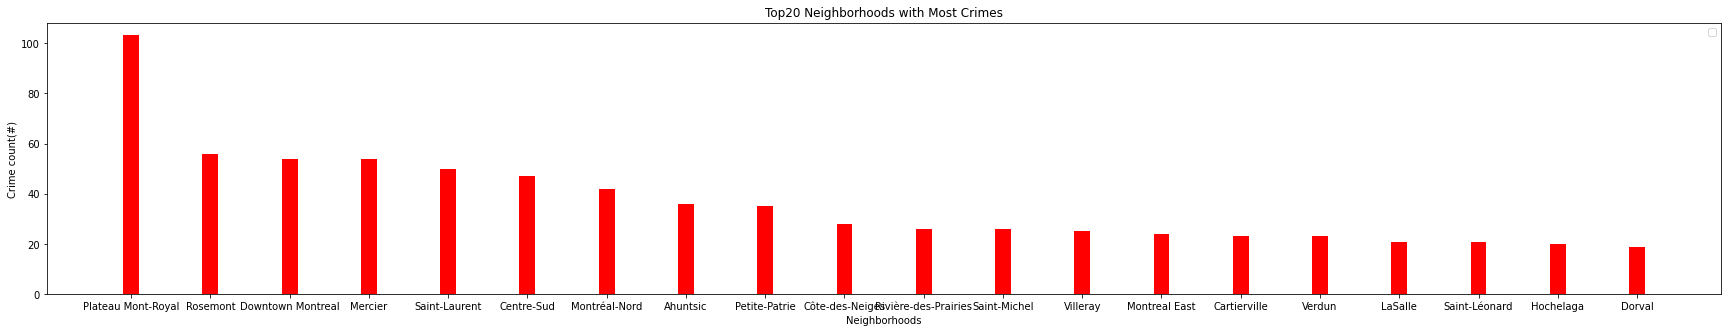

In [20]:
#fig, ax = plt.subplots()
#width = np.diff(dates).min()
#ax.xaxis_date()
#fig.autofmt_xdate()
#dfMisChief = dfDummyCrime.sort_values(ascending=False, by=['Mischief'])
plt.figure(figsize=(30, 5))
plt.title("Top20 Neighborhoods with Most Crimes")
plt.legend(labels = ['Total'])
# This is the location for the annotated text
#i = 1.0
#j = 2000
#for i in range(len(dfDummyCrime['Neighborhood'].head(20))):
#    plt.annotate(dfDummyCrime['Total'][i], (-0.1 + i, dfDummyCrime['Total'] + j))
plt.bar(dfDummyCrime['Neighborhood'].head(20),dfDummyCrime['Total'].head(20),color="red",align='center',width=0.2)
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

In [21]:
dfMod = dfDummyCrime.transpose()
dfMod.columns = dfMod.iloc[0]
dfMod = dfMod.iloc[1:]
dfMod.columns = [x.lower() for x in dfMod.columns]
dfMod.columns = [unidecode.unidecode(x) for x in dfMod.columns]
dfMod['cote-des-neiges-notre-dame-de-grace'] = dfMod['cote-des-neiges'] + dfMod['notre-dame-de-grace']
dfMod['pierrefonds-roxboro'] = dfMod['pierrefonds-roxboro'] + dfMod['pierrefonds']
dfMod['mont-royal'] = dfMod['mount royal']
dfMod['le plateau-mont-royal'] = dfMod['plateau mont-royal']
dfMod["l'ile-bizard-sainte-genevieve"] = dfMod['l\'ile-bizard'] + dfMod['sainte-genevieve']
dfMod['le sud-ouest'] = dfMod['saint-henri'] + dfMod['ville emard'] + dfMod['pointe-saint-charles']
dfMod['lachine'] = dfMod['ville saint-pierre'] + dfMod['lachine'] + dfMod['petite-bourgogne'] + dfMod['griffintown']
dfMod['ahuntsic-cartierville'] = dfMod['ahuntsic'] + dfMod['cartierville']
dfMod['cote-saint-luc'] = dfMod['cote saint-luc']
dfMod['montreal-ouest'] = dfMod['montreal west']
dfMod['montreal-est'] = dfMod['montreal east']
dfMod['verdun'] = dfMod['verdun'] + dfMod['l\'ile-des-soeurs']
dfMod['rosemont-la petite-patrie'] = dfMod['petite-patrie'] + dfMod['rosemont']
dfMod['riviere-des-prairies-pointe-aux-trembles'] = dfMod['pointe-aux-trembles'] + dfMod['riviere-des-prairies']
dfMod['mercier-hochelaga-maisonneuve'] = dfMod['maisonneuve'] + dfMod['mercier'] + dfMod['hochelaga']
dfMod['villeray-saint-michel-parc-extension'] = dfMod['villeray'] + dfMod['saint-michel'] + dfMod['parc-extension']
dfMod['ville-marie'] = dfMod['downtown montreal'] + dfMod['old montreal'] + dfMod['centre-sud']
dfMod.drop(['cote-des-neiges', 'notre-dame-de-grace','pierrefonds','plateau mont-royal','l\'ile-bizard','downtown montreal','ville emard','old montreal','centre-sud','villeray','saint-michel','parc-extension','maisonneuve','mercier','hochelaga','pointe-aux-trembles','riviere-des-prairies','petite-patrie','rosemont','l\'ile-des-soeurs','montreal east','montreal west','cote saint-luc','ahuntsic','cartierville','ville saint-pierre','petite-bourgogne','griffintown','saint-henri','ville emard','pointe-saint-charles','sainte-genevieve','mount royal'], axis=1, inplace=True)

In [22]:
dfCrimeTranspose = dfMod.transpose()
dfCrimeTranspose.reset_index(inplace=True)
dfCrimeTranspose.rename(columns={'index':'Neighborhood'}, inplace=True)
dfCrimeTranspose = dfCrimeTranspose.append({'Neighborhood':'baie d\'urfe', 'Break in':0, 'Mischief':0,'Robbery involving vehicule':0,'Robbery of Vehicule':0,'Armed Robbery':0,'Total':0},ignore_index=True)
dfCrimeTranspose
for x in dfCrimeTranspose['Neighborhood']:
    print(x)

saint-laurent
montreal-nord
verdun
lasalle
saint-leonard
dorval
anjou
pointe-claire
lachine
outremont
westmount
dollard-des-ormeaux
hampstead
sainte-anne-de-bellevue
kirkland
pierrefonds-roxboro
senneville
beaconsfield
cote-des-neiges-notre-dame-de-grace
mont-royal
le plateau-mont-royal
l'ile-bizard-sainte-genevieve
le sud-ouest
ahuntsic-cartierville
cote-saint-luc
montreal-ouest
montreal-est
rosemont-la petite-patrie
riviere-des-prairies-pointe-aux-trembles
mercier-hochelaga-maisonneuve
villeray-saint-michel-parc-extension
ville-marie
baie d'urfe


In [23]:
center = [45.5017,-73.5673]
def show_choropleth_map(geo_data, dataframe, columns, legend_name):
    map = folium.Map(location=(center[0], center[1]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(map)

    return map
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfCrimeTranspose,
                    columns=['Neighborhood', 'Total'],
                    legend_name='Crimes',
                    )
plugins.ScrollZoomToggler().add_to(map)
map

In [24]:
dfMtlDensity = pd.read_excel("MontrealStatistique.XLS", sheet_name=2, header=2, usecols=[0,1])
dfMtlDensity.columns = ['Neighborhood','Population']
dfMtlDensity = dfMtlDensity[(dfMtlDensity["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlDensity["Neighborhood"] != 'Ville de Montréal') & (dfMtlDensity["Neighborhood"] != 'Autres villes') & (dfMtlDensity["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlDensity = dfMtlDensity.reset_index(drop=True)
dfMtlDensity = dfMtlDensity.iloc[:33]
for x,row in enumerate(dfMtlDensity.iterrows()) :
    dfMtlDensity.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlDensity.at[x,"Neighborhood"].lower())
dfMtlDensity

Neighborhood  Population
0                      ahuntsic-cartierville    134245.0
1                                      anjou     42796.0
2        cote-des-neiges-notre-dame-de-grace    166520.0
3                                    lachine     44489.0
4                                    lasalle     76853.0
5                      le plateau-mont-royal    104000.0
6                               le sud-ouest     78151.0
7              l'ile-bizard-sainte-genevieve     18413.0
8              mercier-hochelaga-maisonneuve    136024.0
9                              montreal-nord     84234.0
10                                 outremont     23954.0
11                       pierrefonds-roxboro     69297.0
12  riviere-des-prairies-pointe-aux-trembles    106743.0
13                 rosemont-la petite-patrie    139590.0
14                             saint-laurent     98828.0
15                             saint-leonard     78305.0
16                                    verdun     69229.0
17                               ville-marie     89170.0
18      villeray-saint-michel-parc-extension    143853.0
19                               baie-d'urfe      3823.0
20                              beaconsfield     19324.0
21                            cote-saint-luc     32448.0
22                       dollard-des ormeaux     48899.0
23                                    dorval     18980.0
24                                 hampstead      6973.0
25                                  kirkland     20151.0
26                              montreal-est      3850.0
27                            montreal-ouest      5050.0
28                                mont-royal     20276.0
29                             pointe-claire     31380.0
30                   sainte-anne-de-bellevue      4958.0
31                                senneville       921.0
32                                 westmount     20312.0

In [25]:
dfMtlRealEstateAVG = pd.read_excel("MontrealStatistique.XLS", sheet_name=22, header=2, usecols=[0,7])
dfMtlRealEstateAVG.columns = ['Neighborhood','Price']
dfMtlRealEstateAVG = dfMtlRealEstateAVG[(dfMtlRealEstateAVG["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlRealEstateAVG["Neighborhood"] != 'Ville de Montréal') & (dfMtlRealEstateAVG["Neighborhood"] != 'Autres villes') & (dfMtlRealEstateAVG["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlRealEstateAVG = dfMtlRealEstateAVG.reset_index(drop=True)
dfMtlRealEstateAVG = dfMtlRealEstateAVG.iloc[:33]
for x,row in enumerate(dfMtlRealEstateAVG.iterrows()):
    dfMtlRealEstateAVG.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlRealEstateAVG.at[x,"Neighborhood"].lower())
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'baie-d\'urfe':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'baie d\'urfe'
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'dollard-des ormeaux':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'dollard-des-ormeaux'
dfMtlRealEstateAVG

Neighborhood    Price
0                      ahuntsic-cartierville   451986
1                                      anjou   366417
2        cote-des-neiges-notre-dame-de-grace   548055
3                                    lachine   368620
4                                    lasalle   431541
5                      le plateau-mont-royal   479977
6                               le sud-ouest   384460
7              l'ile-bizard-sainte-genevieve   452415
8              mercier-hochelaga-maisonneuve   351204
9                              montreal-nord   348935
10                                 outremont   896722
11                       pierrefonds-roxboro   360055
12  riviere-des-prairies-pointe-aux-trembles   307583
13                 rosemont-la petite-patrie   424521
14                             saint-laurent   463060
15                             saint-leonard   533135
16                                    verdun   463337
17                               ville-marie   525007
18      villeray-saint-michel-parc-extension   396855
19                               baie d'urfe   643397
20                              beaconsfield   603087
21                            cote-saint-luc   525526
22                       dollard-des-ormeaux   422109
23                                    dorval   414180
24                                 hampstead  1147558
25                                  kirkland   526075
26                              montreal-est   277030
27                            montreal-ouest   631370
28                                mont-royal  1017819
29                             pointe-claire   416061
30                   sainte-anne-de-bellevue   405518
31                                senneville   982011
32                                 westmount  1425737

In [26]:
center = [45.5017,-73.5673]
def show_choropleth_map(geo_data, dataframe, columns, legend_name):
    map = folium.Map(location=(center[0], center[1]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color='BuPu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(map)

    return map
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMtlRealEstateAVG,
                    columns=['Neighborhood', 'Price'],
                    legend_name='Real Estate Price',
                    )
plugins.ScrollZoomToggler().add_to(map)
map

In [54]:
dfMtlCrimeGrouped = dfCrimeTranspose.drop(['Total'], axis=1)
colName = ['Neighborhood', 'Crime Type']
tempDf = pd.DataFrame(columns = colName)
for row in dfMtlCrimeGrouped.iterrows():
    (neigh, breakIn, mischief, robInvolve, robV, armed) = row[1]
    for x in range(breakIn):
        tempDf = tempDf.append({'Neighborhood':neigh,'Crime Type':'Break in'},ignore_index=True)
    for x in range(mischief):
        tempDf = tempDf.append({'Neighborhood':neigh,'Crime Type':'Mischief'},ignore_index=True)
    for x in range(robInvolve):
        tempDf = tempDf.append({'Neighborhood':neigh,'Crime Type':'Robbery involving vehicule'},ignore_index=True)
    for x in range(robV):
        tempDf = tempDf.append({'Neighborhood':neigh,'Crime Type':'Robbery of Vehicule'},ignore_index=True)
    for x in range(armed):
        tempDf = tempDf.append({'Neighborhood':neigh,'Crime Type':'Armed Robbery'},ignore_index=True)
dfCrimeDummy = pd.get_dummies(tempDf[["Crime Type"]])
dfCrimeDummy['Neighborhood'] = tempDf['Neighborhood']
cols = dfCrimeDummy.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfCrimeDummy = dfCrimeDummy[cols]

In [55]:
dfCrimeDummy = dfCrimeDummy.groupby('Neighborhood').mean().reset_index()

In [56]:
#let us run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters

dfMtlCrimeGrouped_cluster = dfCrimeDummy.drop(axis=0, columns='Neighborhood')
kmeans = KMeans(n_clusters =5, random_state=0).fit(dfMtlCrimeGrouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:32]
# dfMtlCrimeGrouped_cluster['Cluster'] = kmeans.labels_[0:32]
# dfMtlCrimeGrouped_cluster['Neighborhood'] = dfMtlCrimeGrouped['Neighborhood']
# dfMtlCrimeGrouped_cluster.sort_values(ascending=True, by=['Cluster'], inplace=True)
# dfMtlCrimeGrouped_cluster

array([1, 3, 2, 1, 4, 1, 3, 4, 4, 1, 1, 3, 4, 1, 1, 1, 3, 4, 1, 4, 0, 3,
       1, 4, 1, 1, 0, 3, 4, 1, 1, 4])

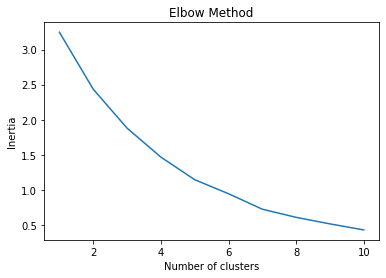

In [57]:
tabKInert = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(dfMtlCrimeGrouped_cluster)
    tabKInert.append(kmeans.inertia_)
plt.plot(range(1,11), tabKInert)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [58]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
kmeans.fit(dfMtlCrimeGrouped_cluster)

dfCrimeDummy['Cluster'] = kmeans.labels_[0:32]

In [61]:
#dfCrimeDummy.to_excel(r'MontrealCrimeMeanAndCluster.xlsx')
dfCrimeDummy

Neighborhood  Crime Type_Armed Robbery  \
0                      ahuntsic-cartierville                  0.050847   
1                                      anjou                  0.000000   
2                               beaconsfield                  0.000000   
3        cote-des-neiges-notre-dame-de-grace                  0.044444   
4                             cote-saint-luc                  0.000000   
5                        dollard-des-ormeaux                  0.000000   
6                                     dorval                  0.000000   
7                                  hampstead                  0.000000   
8                                   kirkland                  0.000000   
9              l'ile-bizard-sainte-genevieve                  0.000000   
10                                   lachine                  0.119048   
11                                   lasalle                  0.142857   
12                     le plateau-mont-royal                  0.058252   
13                              le sud-ouest                  0.107143   
14             mercier-hochelaga-maisonneuve                  0.054945   
15                                mont-royal                  0.222222   
16                              montreal-est                  0.000000   
17                             montreal-nord                  0.047619   
18                            montreal-ouest                  0.000000   
19                                 outremont                  0.000000   
20                       pierrefonds-roxboro                  0.200000   
21                             pointe-claire                  0.000000   
22  riviere-des-prairies-pointe-aux-trembles                  0.047619   
23                 rosemont-la petite-patrie                  0.032967   
24                             saint-laurent                  0.040000   
25                             saint-leonard                  0.000000   
26                   sainte-anne-de-bellevue                  0.000000   
27                                senneville                  0.000000   
28                                    verdun                  0.037037   
29                               ville-marie                  0.138889   
30      villeray-saint-michel-parc-extension                  0.030769   
31                                 westmount                  0.000000   

    Crime Type_Break in  Crime Type_Mischief  \
0              0.101695             0.203390   
1              0.250000             0.187500   
2              0.000000             0.000000   
3              0.266667             0.311111   
4              0.500000             0.285714   
5              0.100000             0.300000   
6              0.105263             0.105263   
7              0.444444             0.000000   
8              0.333333             0.166667   
9              0.250000             0.250000   
10             0.190476             0.261905   
11             0.285714             0.047619   
12             0.378641             0.300971   
13             0.178571             0.357143   
14             0.208791             0.263736   
15             0.111111             0.333333   
16             0.083333             0.250000   
17             0.309524             0.190476   
18             0.000000             0.500000   
19             0.636364             0.090909   
20             0.000000             0.600000   
21             0.230769             0.000000   
22             0.119048             0.333333   
23             0.307692             0.274725   
24             0.220000             0.260000   
25             0.285714             0.380952   
26             0.000000             0.500000   
27             0.333333             0.000000   
28             0.407407             0.333333   
29             0.231481             0.277778   
30             0.276923             0.261538   
31             0.500000             0.200000   

    